In [27]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn import metrics
import pickle
from scipy import stats
sns.set_theme()

In [3]:
clubb_dir = '/home/tsw35/tyche/clubb/'
les_dir= '/stor/soteria/hydro/shared/data/tylersclutter/doz_tylertrim/'
daylist=os.listdir(clubb_dir+'sgp_1c')
daylist.sort()

In [73]:
dbfile = open('../tdata_base.p', 'rb')     
tdata = pickle.load(dbfile)

In [74]:
def cts_to_string(cts):
    out=[]
    for ct in cts:
        sp=str(ct).split('0')
        if(len(sp)<4):
            if 'e-04' in str(ct):
                out.append('cr20ct0.000'+str(ct)[0]+'cf0.8')
            elif 'e-05' in str(ct):
                out.append('cr20ct'+str(ct)+'cf0.8')
        else:
            out.append('cr20ct0.000'+sp[4]+'cf0.8')
    return out

ct_n =np.linspace(.00001,.0005,50,dtype='f4')
ct_s= cts_to_string(ct_n) #filename strings

In [75]:
tdata['circ_pow']=[]
for day in daylist:
    print(day,end='...')
    circ_pow=[]
    for i in range(len(ct_s)):
        f=ct_s[i]
        ct=ct_n[i]
        fp = nc.Dataset(clubb_dir+'circ_tune/'+day[4:]+'/'+f+'/k_2/clusters.nc','r')
        try:
            ur=fp['u_r'][:]
        except:
            circ_pow.append(-1)
            continue
        ur[ur<0]=0
        circ_pow.append(np.sum(ur)*ct)
    circ_pow=np.array(circ_pow)
    tdata['circ_pow'].append(circ_pow)

sgp_20150606...sgp_20150609...sgp_20150627...sgp_20150801...sgp_20150829...sgp_20160518...sgp_20160530...sgp_20160610...sgp_20160611...sgp_20160614...sgp_20160619...sgp_20160625...sgp_20160716...sgp_20160719...sgp_20160720...sgp_20160818...sgp_20160819...sgp_20160830...sgp_20170403...sgp_20170405...sgp_20170509...sgp_20170524...sgp_20170527...sgp_20170605...sgp_20170609...sgp_20170614...sgp_20170626...sgp_20170627...sgp_20170629...sgp_20170630...sgp_20170704...sgp_20170705...sgp_20170709...sgp_20170712...sgp_20170716...sgp_20170717...sgp_20170719...sgp_20170720...sgp_20170721...sgp_20170725...sgp_20170728...sgp_20170802...sgp_20170826...sgp_20170828...sgp_20170830...sgp_20170922...sgp_20170923...sgp_20170924...sgp_20180514...sgp_20180522...sgp_20180523...sgp_20180529...sgp_20180530...sgp_20180531...sgp_20180606...sgp_20180618...sgp_20180619...sgp_20180704...sgp_20180705...sgp_20180707...sgp_20180709...sgp_20180710...sgp_20180711...sgp_20180712...sgp_20180731...sgp_20180805...sgp_201808

In [76]:
def get_lhet(run_dir):
    fp_=open(run_dir+'/tw_run_param.txt','r')
    for line in fp_:
        if 'l_het' in line:
            return float(line.split(' ')[4])
    return 5

In [84]:
def compute_LE(LE,clst_):
    LEclst=np.zeros((LE.shape[0],2))
    for t in range(LE.shape[0]):
        LEclst[t,0]=np.mean(LE[t][clst_==0])
        LEclst[t,1]=np.mean(LE[t][clst_==1])
    return LEclst

In [135]:
lhet=[]
for day in daylist:
    folder=day[4:]
    lhet.append(get_lhet(clubb_dir+'sgp_cpl_m/sgp_'+folder))
print(np.mean(lhet))

30406.26534596935


In [128]:
######################
#### LOAD IN VARS ####
######################
#tdata['vars']['Tsfc']=[]
tdata['vars']['Tatm']=[] # bottom 25
tdata['vars']['rtm']=[] # bottom 25
tdata['vars']['p_blh']=[] # 95pct boundary layer height
tdata['vars']['u_s'] =[] #windspeed
tdata['vars']['d_H'] =[]
#tdata['vars']['u_dir']=[] #wind direction relative to het
tdata['vars']['d_LE']=[]
tdata['vars']['std_H']=[]
#tdata['vars']['lhet']=[]
#tdata['vars']['circ_h']=[]
#tdata['vars']['circ_v']=[]
tdata['vars']['m_H']=[]
tdata['vars']['m_LE']=[]
for day in daylist:
    folder=day[4:]
    fp2c_zt=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/agg_outzt.nc','r')
    fp2c_zm=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/agg_outzm.nc','r')
    fp2c_sfc=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/agg_outsfc.nc','r')
    #fp2c_sfc1=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/c_1/output/arm_sfc.nc','r')
    #fp2c_sfc2=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/c_2/output/arm_sfc.nc','r')
    fp2c_clst=nc.Dataset(clubb_dir+'sgp_nocpl_m/sgp_'+folder+'/k_2/clusters.nc','r')
    
    #tdata['vars']['Tsfc'].append(np.mean(fp2c_sfc['T_sfc'][:,0,0,0]))
    tdata['vars']['Tatm'].append(np.mean(fp2c_zt['thlm'][:,0:25,0,0]))
    tdata['vars']['rtm'].append(np.mean(fp2c_zt['rtm'][:,0:25,0,0]))
    tdata['vars']['p_blh'].append(np.percentile(fp2c_sfc['blh'][:,0,0,0],95))
    tdata['vars']['u_s'].append(np.mean((fp2c_zt['um'][:,0:25,0,0]**2+\
                                        fp2c_zt['vm'][:,0:25,0,0]**2)**(1/2)))
    tdata['vars']['d_H'].append(np.abs(np.mean(fp2c_clst['H_clst'][4:7,1])\
                                       -np.mean(fp2c_clst['H_clst'][4:7,0])))
    leclst=compute_LE(fp2c_clst['LE'][:],fp2c_clst['cluster'][0,:,:])
    tdata['vars']['d_LE'].append(np.abs(np.mean(leclst[4:7,1])\
                                       -np.mean(leclst[4:7,0])))
    tdata['vars']['std_H'].append(np.mean(np.std(fp2c_clst['H'][4:7,:,:],axis=(1,2))))
    #tdata['vars']['d_LE'].append(np.mean(np.std(fp2c_clst['LE'][4:10,:,:],axis=(1,2))))
    #tdata['vars']['lhet'].append(get_lhet(clubb_dir+'sgp_cpl_m/sgp_'+folder))
    #tdata['vars']['circ_h']
    #tdata['vars']['circ_v']
    tdata['vars']['m_H'].append(np.mean(fp2c_clst['H'][4:10,:,:]))
    tdata['vars']['m_LE'].append(np.mean(fp2c_clst['LE'][4:10,:,:]))

In [125]:
def tindex_to_cpow(tindex,circ_pow):
    cpow=[]
    for i in range(len(tindex)):
        try:
            cpow.append(circ_pow[i][tindex[i]])
        except:
            cpow.append(float('nan'))
    return cpow

In [126]:
tests=['dpv_lwp','dmv_lwp','dpt_lwp','dt1_lwp','dmv_tke','mdt_lwp']
tliml=[-.01,-.01,-.01,-.01,-.01,-.001]
tlimh=[.1,.25,.1,.2,.3,.05]

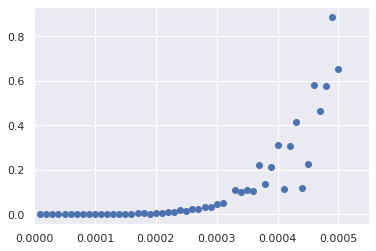

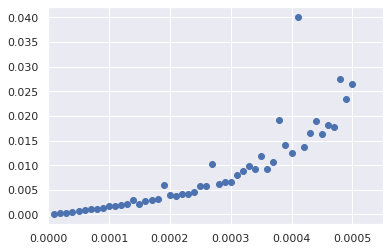

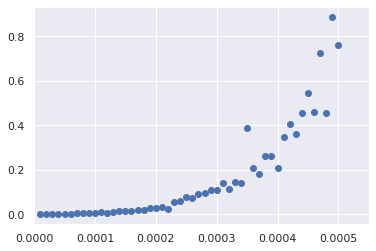

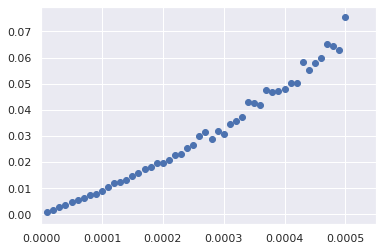

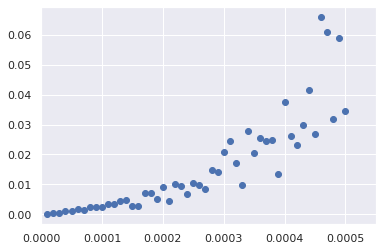

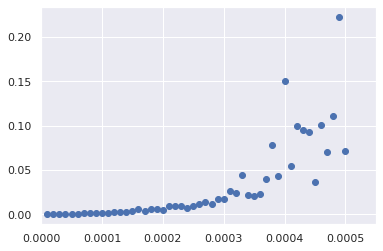

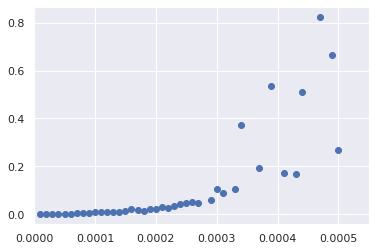

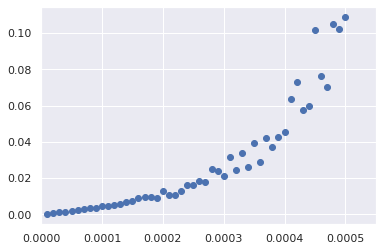

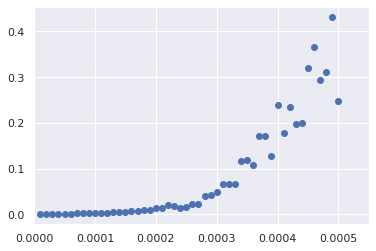

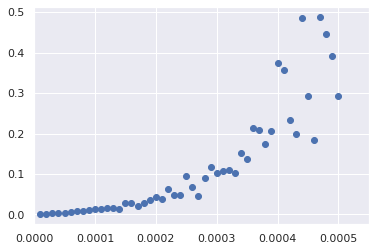

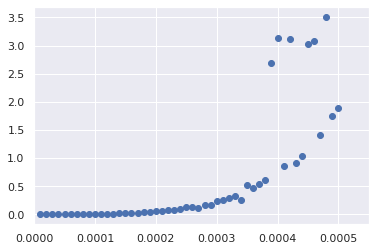

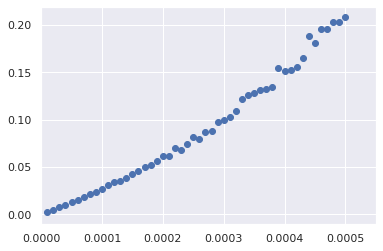

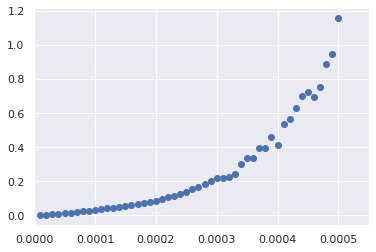

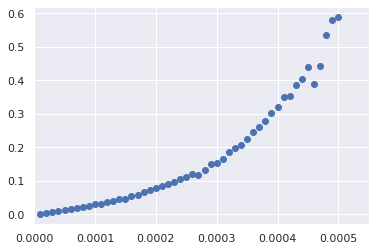

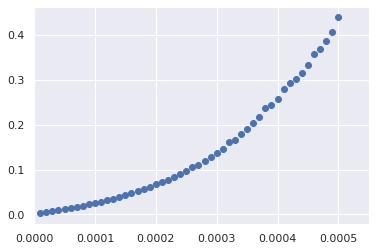

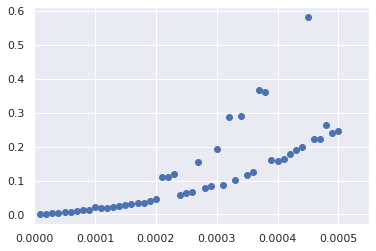

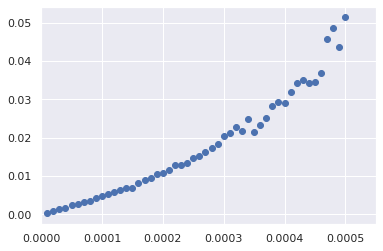

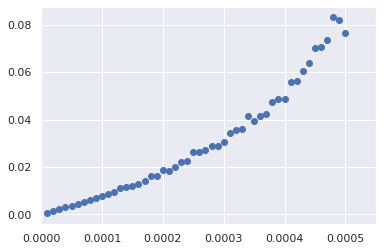

In [148]:
for j in range(18):
    plt.figure()
    cp =np.array(tdata['circ_pow'][j])
    plt.scatter(ct_n,cp)
    plt.xlim(0,.00055)
    plt.ylim(-np.max(cp)*.05,np.max(cp)*1.05)

/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/stor/soteria/hydro/private/tsw35/software/miniconda/envs/jenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplo

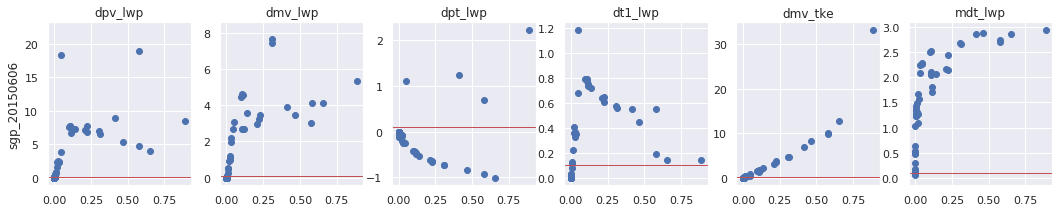

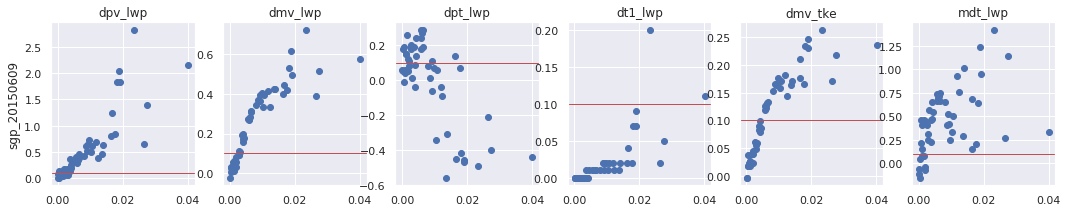

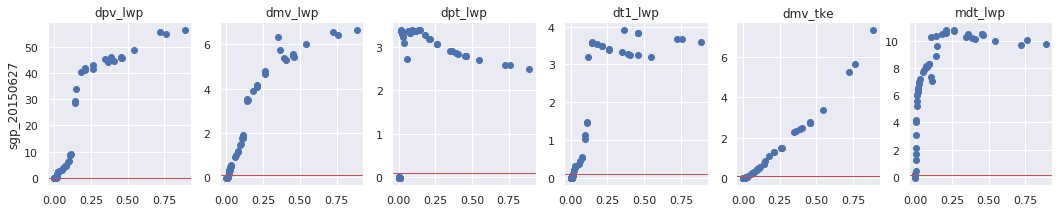

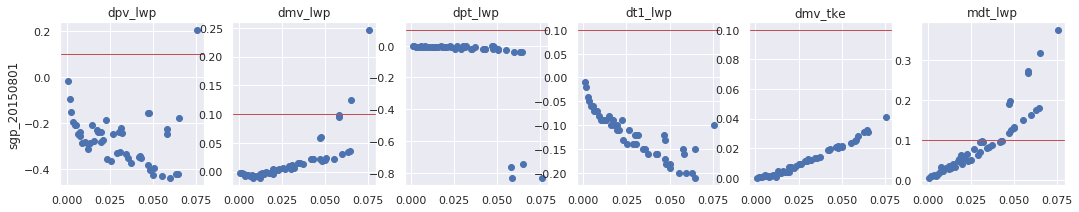

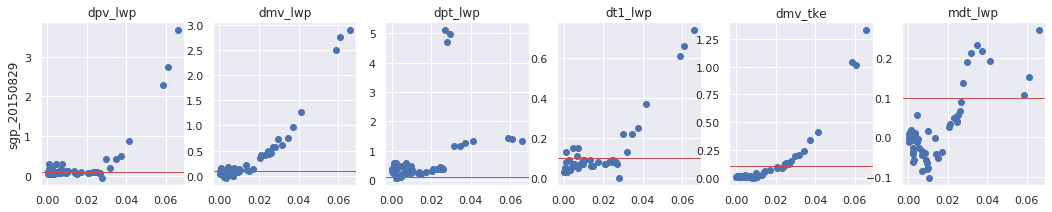

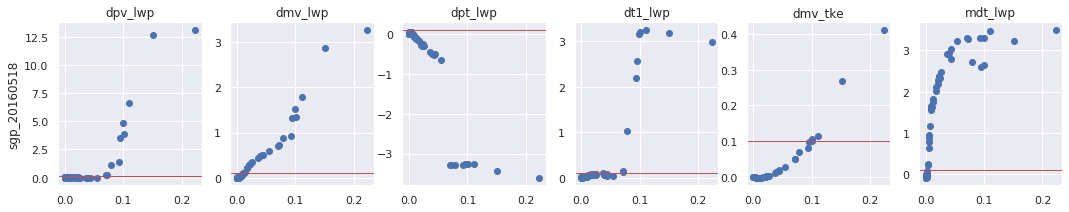

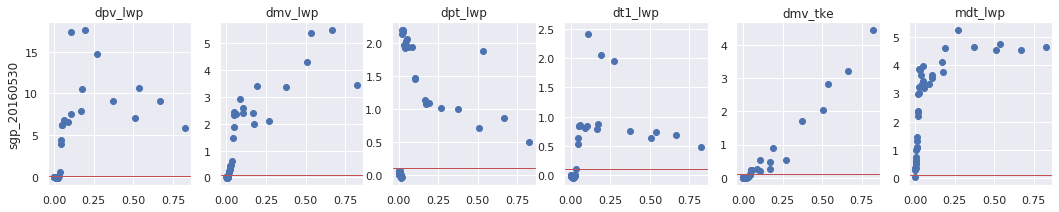

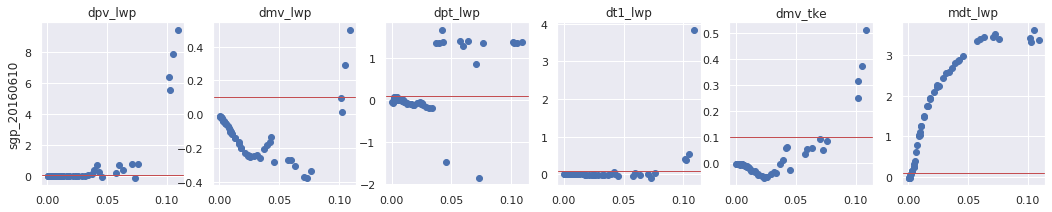

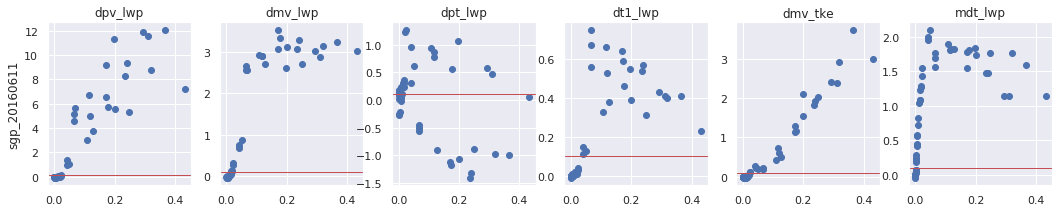

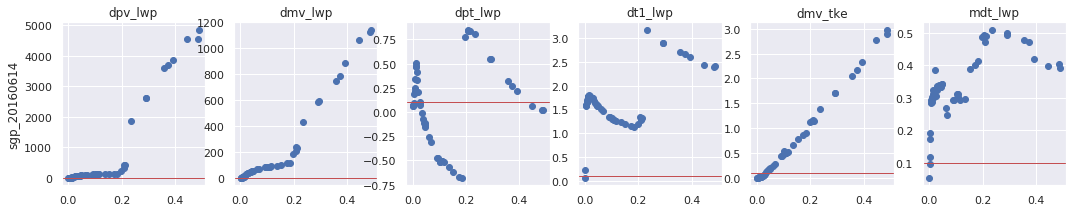

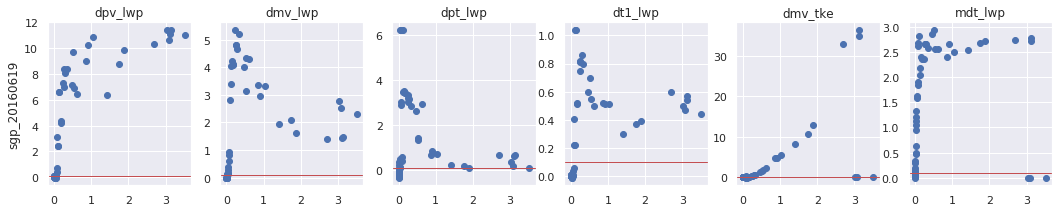

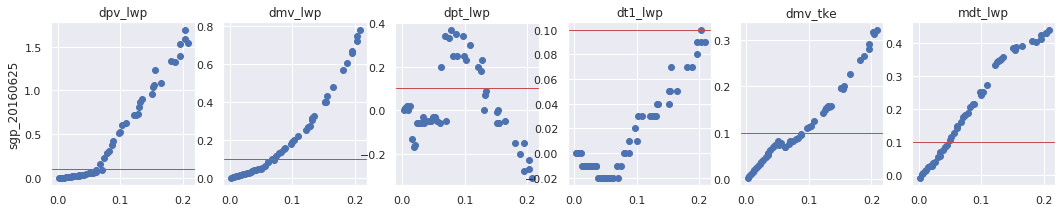

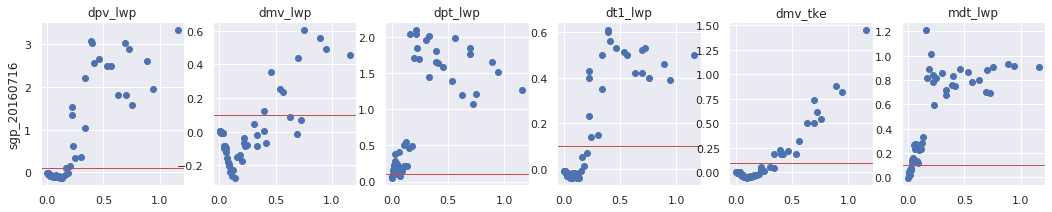

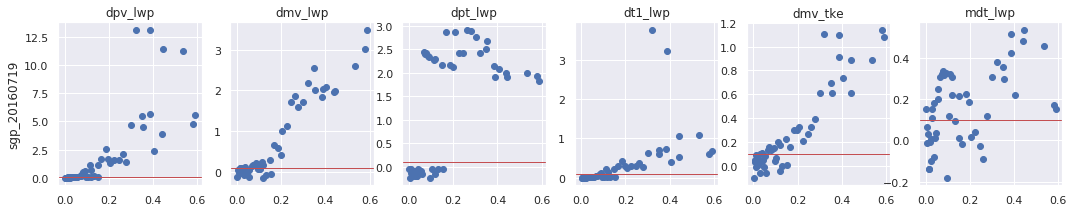

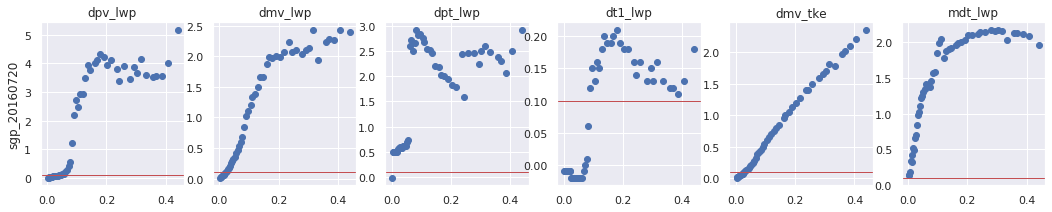

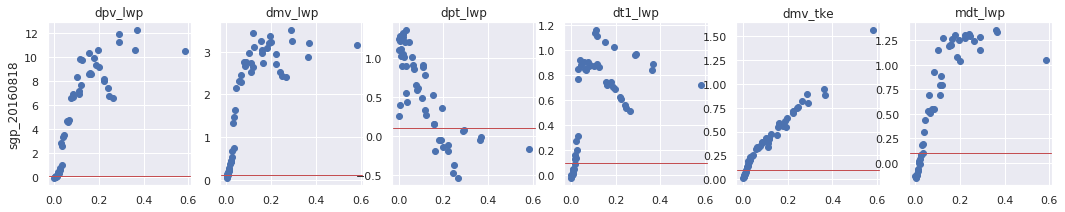

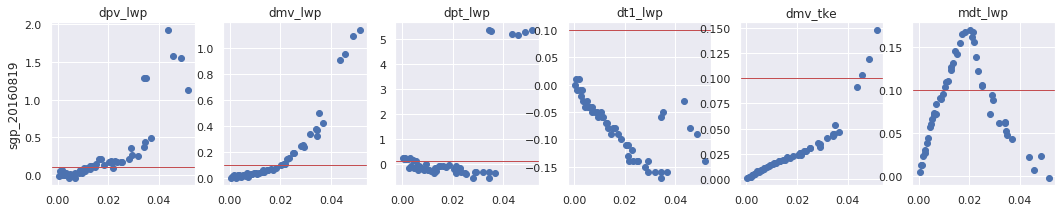

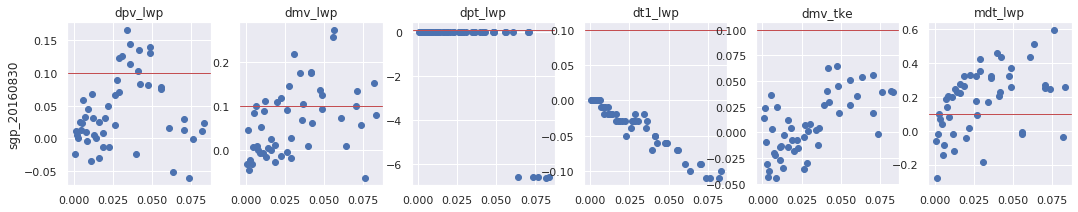

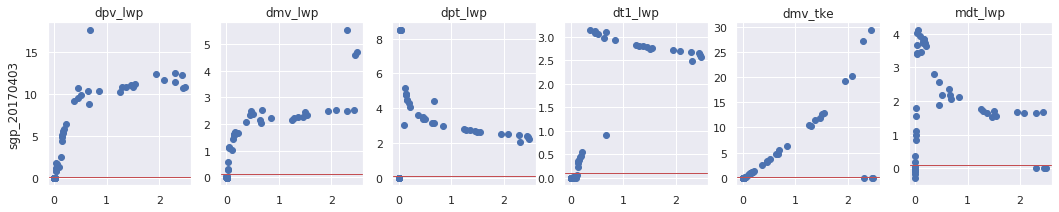

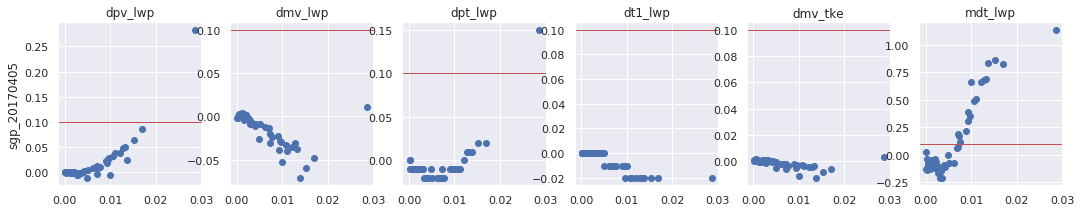

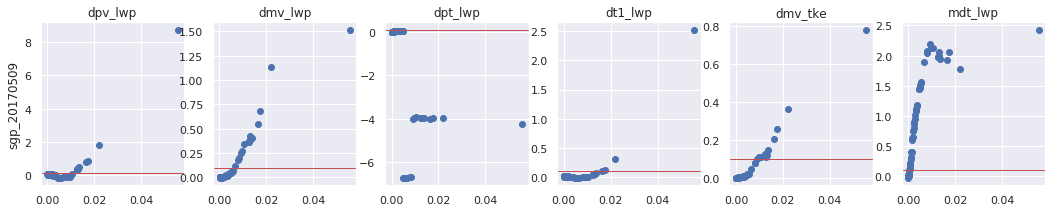

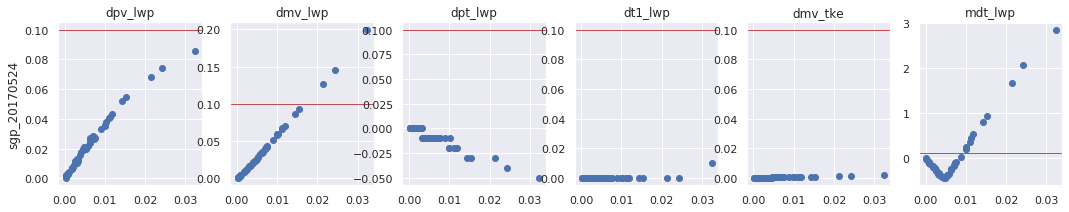

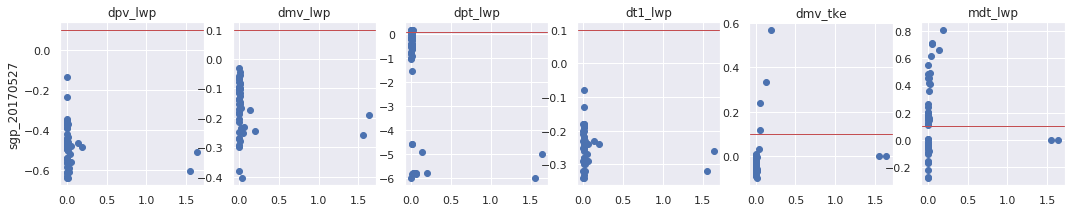

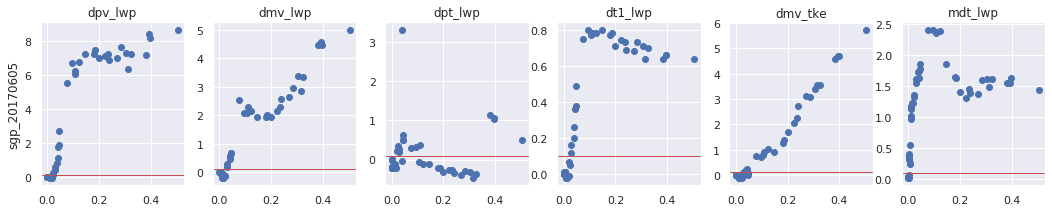

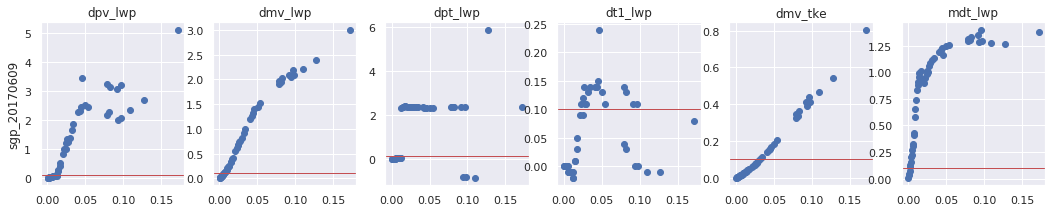

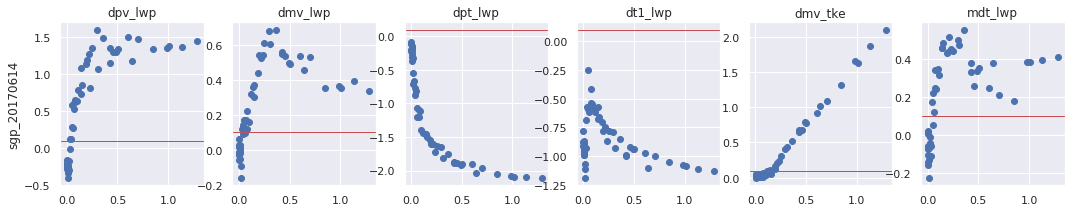

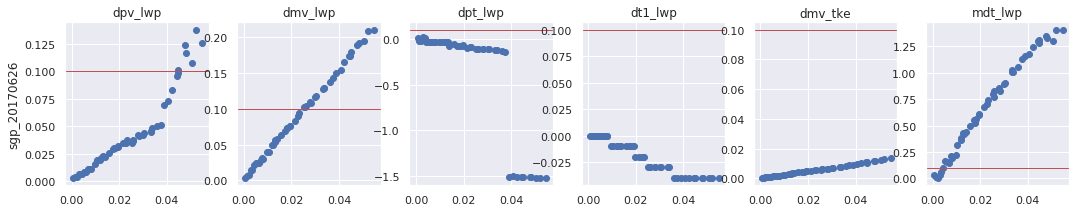

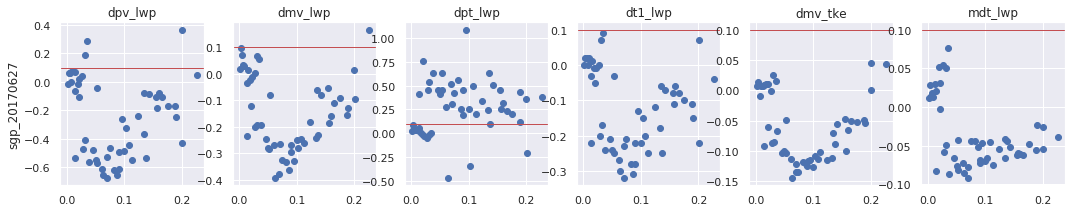

In [174]:
for j in range(28):
    plt.figure(figsize=(18,3))
    i=1 
    for test in tests:
        plt.subplot(1,6,i)
        if i == 1:
            plt.ylabel(daylist[j])
        i=i+1
        cp =np.array(tdata['circ_pow'][j])
        plt.plot(cp,tdata['ntests'][test][j],'o')
        plt.plot([-.05*np.max(cp),1.05*np.max(cp)],[.1,.1],'r-',linewidth=1)
        plt.title(test)
        plt.xlim(-.05*np.max(cp),np.max(cp)+.05*np.max(cp))
    j=j+1

dpv_lwp: 0.0/7.0
dmv_lwp: 0.0/10.0
dpt_lwp: 0.0/18.0
dt1_lwp: 0.0/23.0
dmv_tke: 0.0/17.0
mdt_lwp: 0.0/2.0


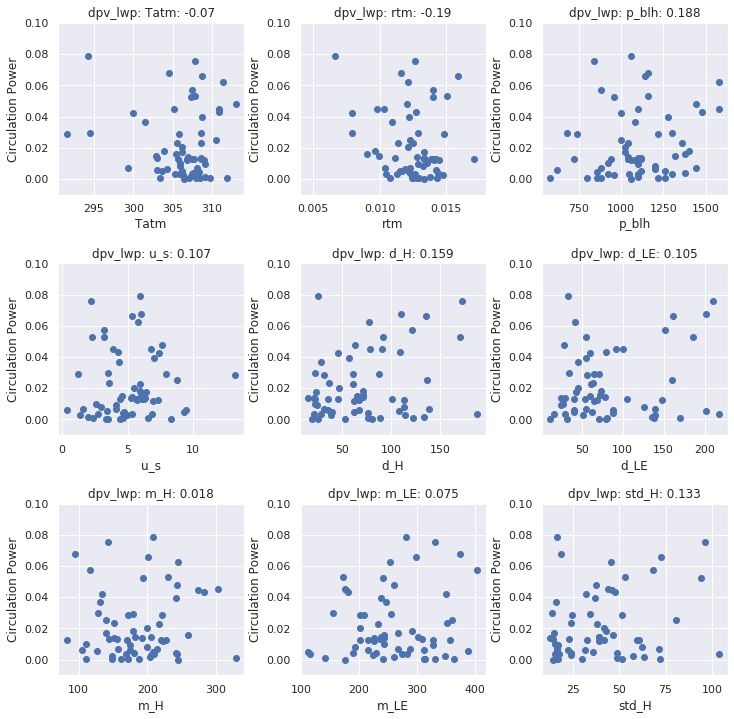

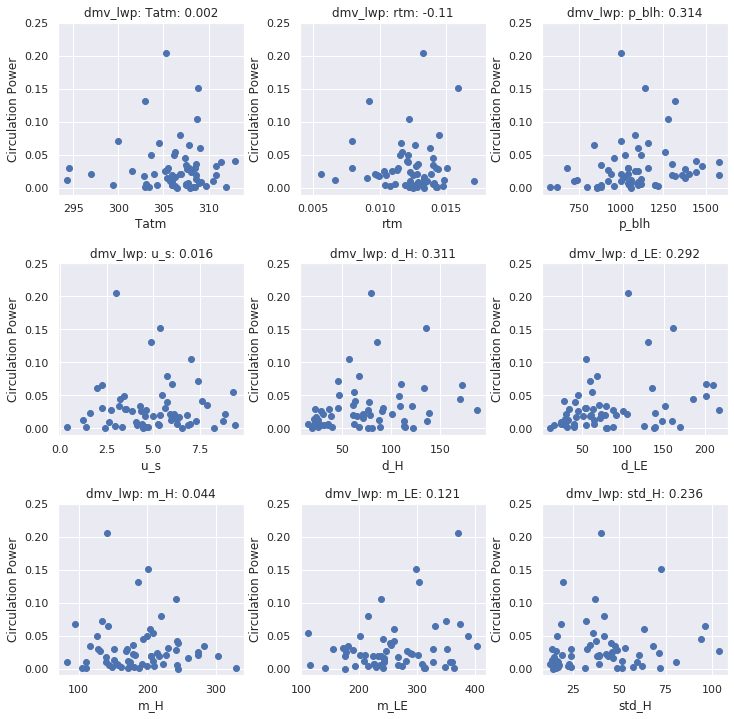

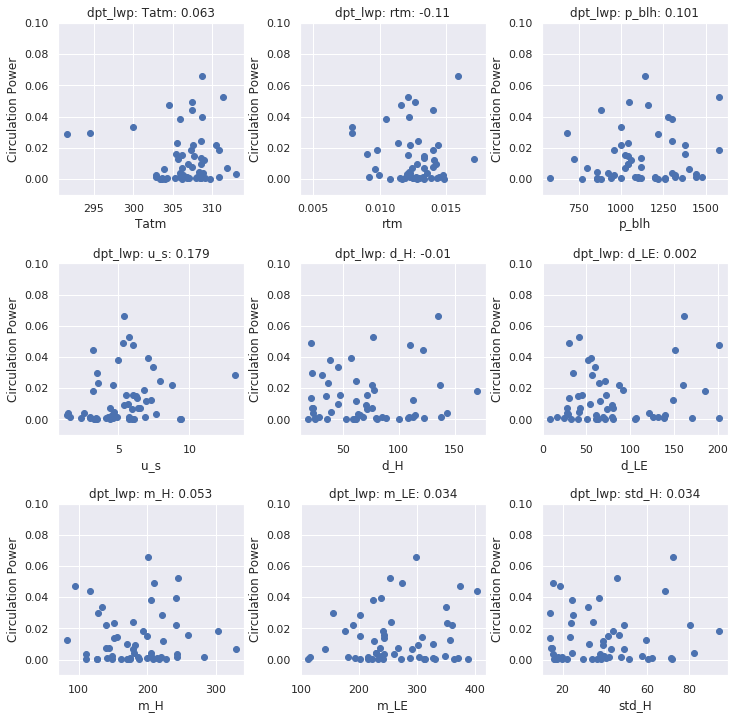

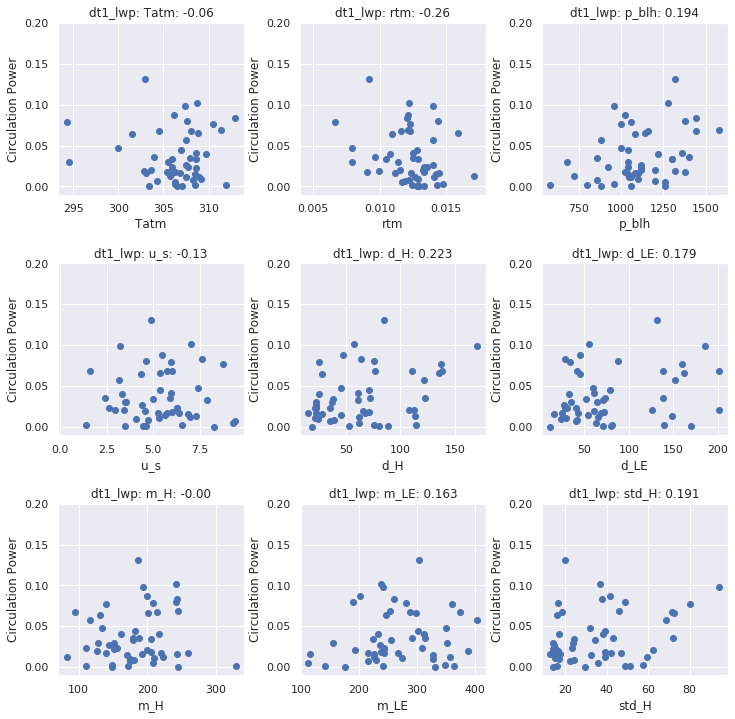

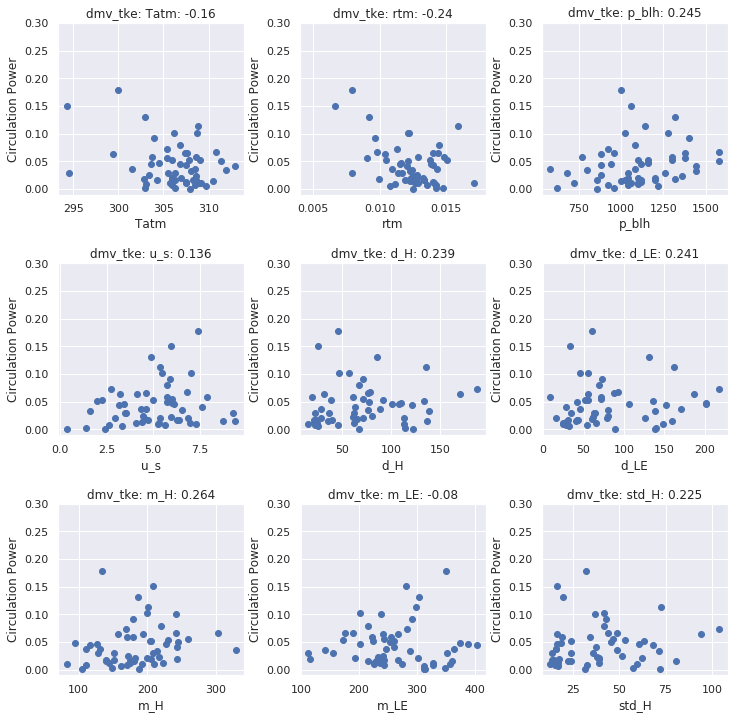

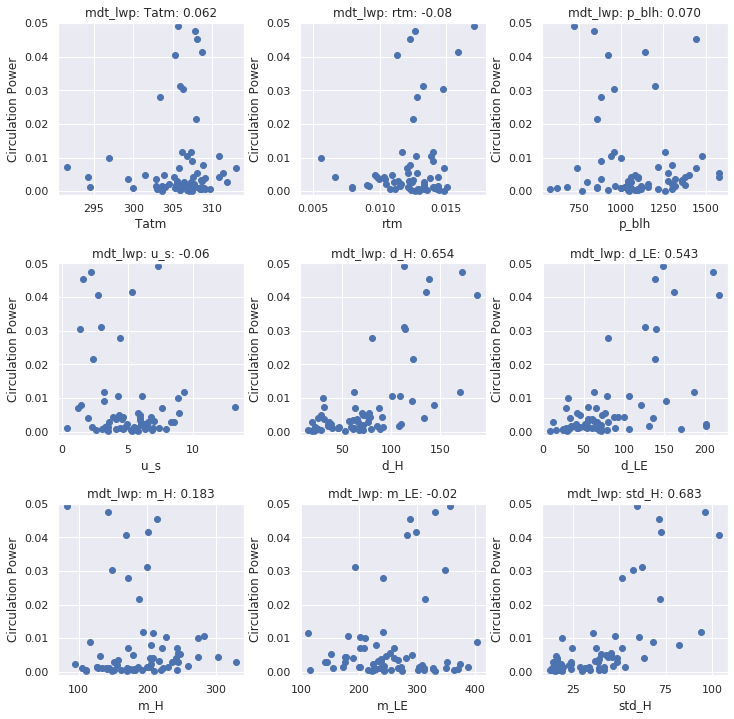

In [172]:
x=0
for test in tests:
    zero_count=0
    nan_count=0
    plt.figure(figsize=(12,12))
    i=1
    for var in tdata['vars'].keys():
        ax=plt.subplot(3,3,i)
        #ax.set_yscale("log")
        i=i+1
        cv=[]
        ct=[]
        cvv=tdata['vars'][var][:]
        ctt=(tindex_to_cpow(tdata['ct_pct10'][test][:],tdata['circ_pow'][:]))
        for j in range(len(tdata['vars'][var][:])):
            if np.isnan(cvv[j]) or np.isnan(ctt[j]):
                nan_count=nan_count+1
                continue
            elif (ctt[j]<=0.0):
                zero_count=zero_count+1
                continue
            elif lhet[j]>40000:
                continue
            else:
                cv.append(cvv[j])
                ct.append(ctt[j])
        plt.scatter(cv,ct)
        pr=stats.spearmanr(cv, ct)[0]
        plt.title(test+': '+var+': '+str(pr)[0:5])
        plt.xlabel(var)
        plt.ylabel('Circulation Power')
        if var =='rtm':
            plt.xlim(0.004,.018)
        #plt.ylim(10**(-4),1)
        plt.ylim(tliml[x],tlimh[x])
    print(test+': '+str(zero_count/9)+'/'+str(nan_count/9))
    plt.subplots_adjust(hspace=.4,wspace=.3)
    x=x+1

In [109]:
def const_circ_pow(circ_pows,val,test):
    testvals=[]
    cps=[]
    for i in range(92):
        cp=np.array(circ_pows[i])
        a = np.argmin(np.abs(cp-val))
        if (a>=49) or (a<1):
            testvals.append(float('nan'))
            cps.append(float('nan'))
        else:
            testvals.append(test[i,a])
            cps.append(cp[a])
    return testvals,cps

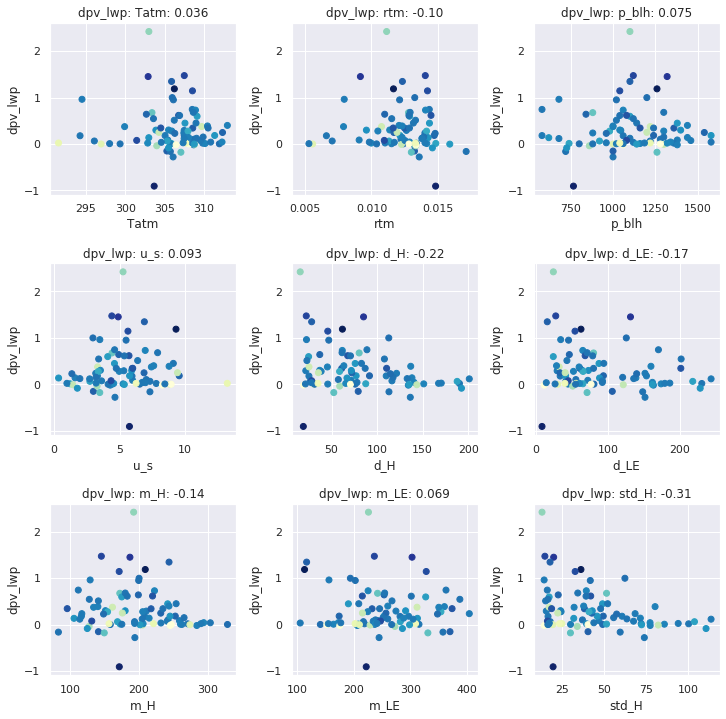

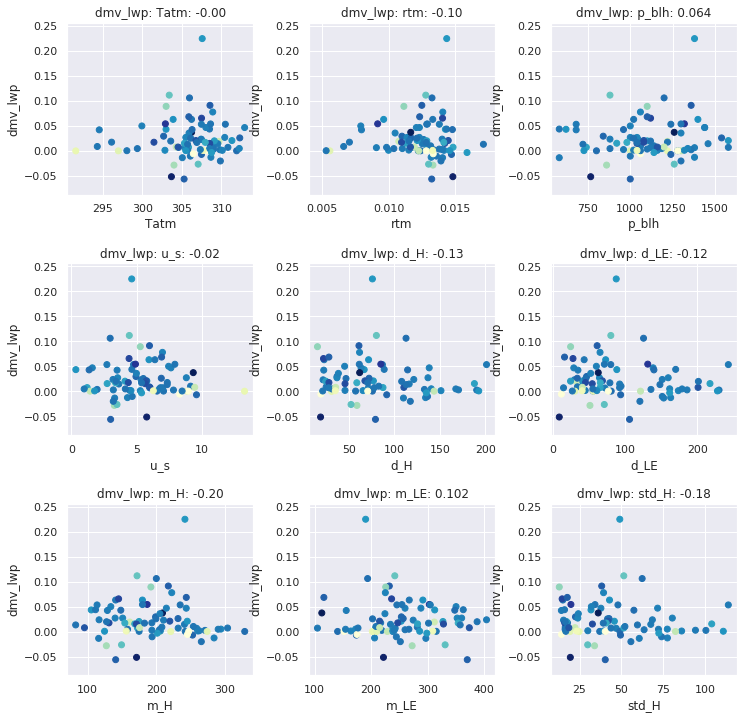

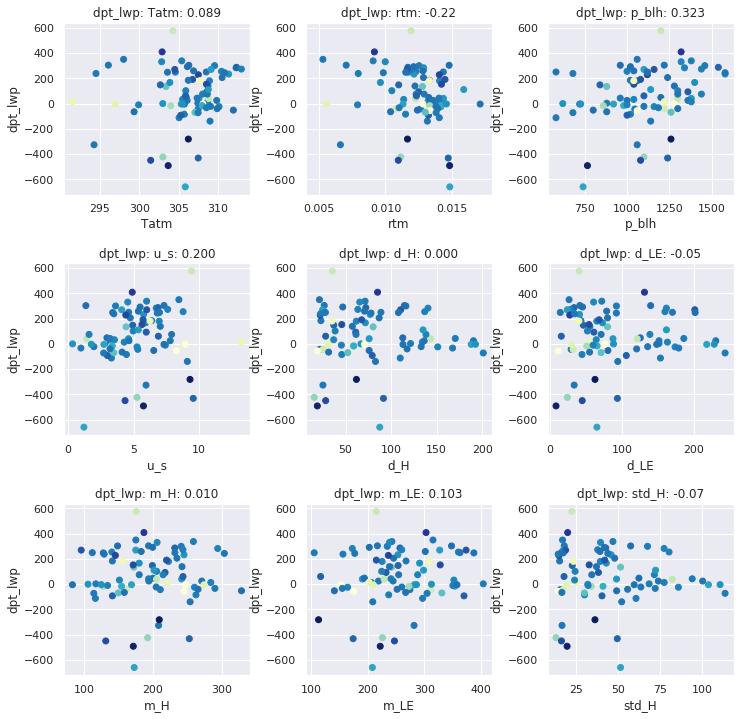

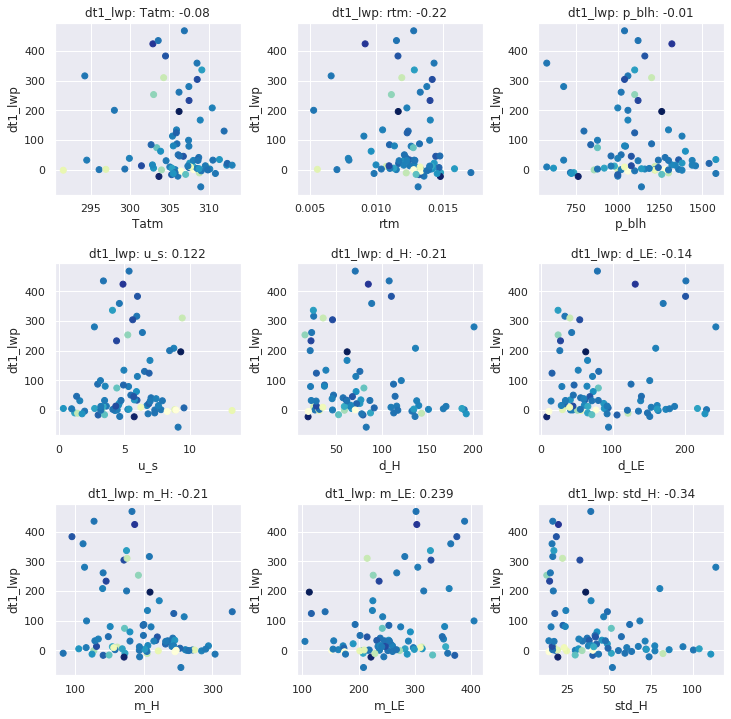

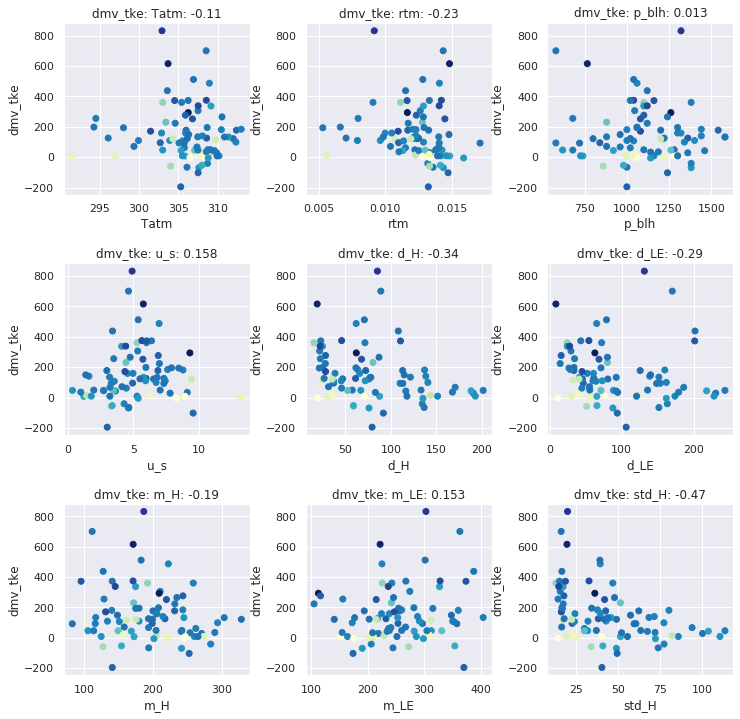

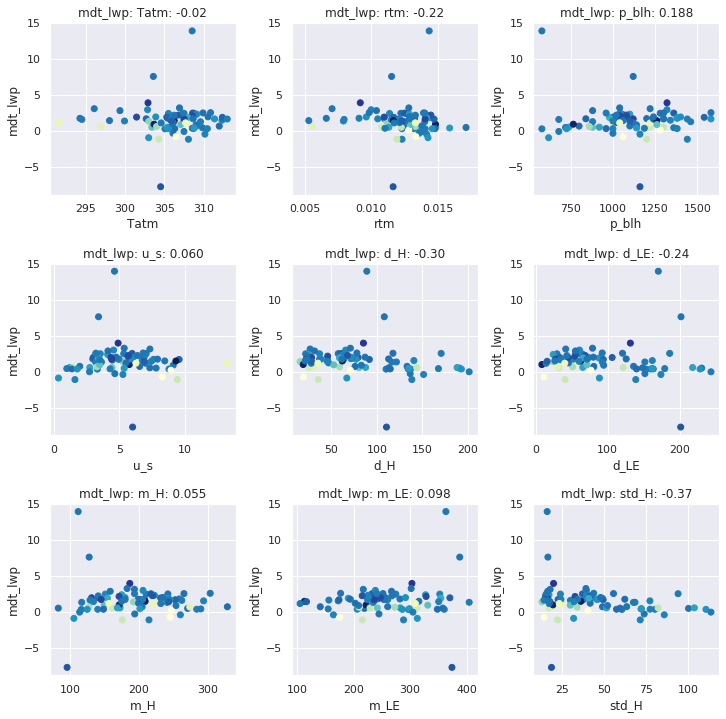

In [173]:
for test in tests:
    plt.figure(figsize=(12,12))
    i=1
    for var in tdata['vars'].keys():
        plt.subplot(3,3,i)
        v=tdata['vars'][var][:]
        t,cp=const_circ_pow(tdata['circ_pow'][:],.1,np.array(tdata['tests'][test][:]))
        i=i+1
        cv=[]
        ct=[]
        cp2=[]
        for j in range(len(tdata['vars'][var][:])):
            if np.isnan(t[j]) or np.isnan(v[j]):
                continue
            else:
                cv.append(v[j])
                ct.append(t[j])
                cp2.append(cp[j])
        color=plt.cm.YlGnBu((cp2-np.min(cp2))/(np.max(cp2)-np.min(cp2)))
        plt.scatter(cv,ct,color=color)
        pr=stats.spearmanr(cv,ct)[0]
        plt.title(test+': '+var+': '+str(pr)[0:5])
        plt.xlabel(var)
        plt.ylabel(test)
        if var =='rtm':
            plt.xlim(0.004,.018)
        #plt.ylim(-10,10)
    plt.subplots_adjust(hspace=.4,wspace=.3)

Text(0.5, 1.0, '')

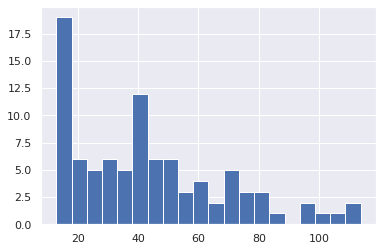

In [154]:
plt.hist(tdata['vars']['std_H'][:],bins=20)
plt.title('')

Text(0.5, 1.0, '')

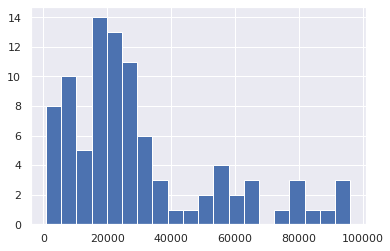

In [156]:
plt.hist(lhet,bins=20)
plt.title('')

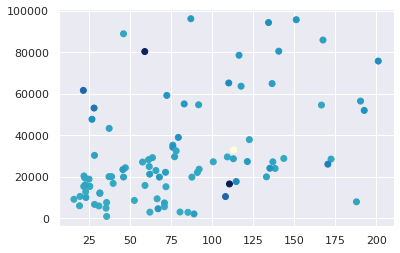

In [166]:
cp3 = np.array(tdata['circ_pow'])[:,25]
color =plt.cm.YlGnBu((cp3-np.min(cp3))/(np.max(cp3)-np.min(cp3)))
plt.scatter(tdata['vars']['d_H'][:],lhet,color=color)

In [41]:
np.argmin(a)

10

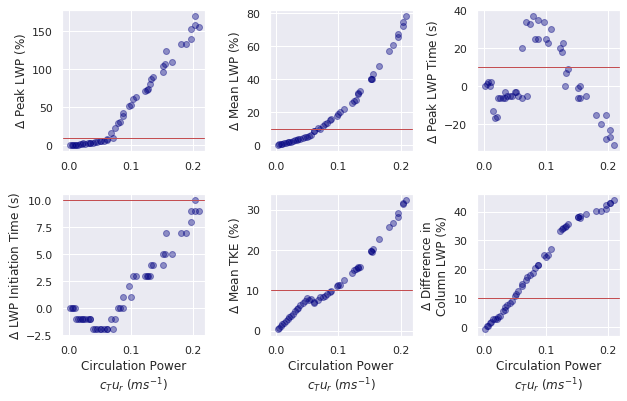

In [214]:
########### PRESENTATION PLOTS #########################
plt.figure(figsize=(10,6))
i=1 
j=11
test_names=[]
ylabels=['$\Delta$ Peak LWP (%)','$\Delta$ Mean LWP (%)','$\Delta$ Peak LWP Time (s)','$\Delta$ LWP Initiation Time (s)','$\Delta$ Mean TKE (%)','$\Delta$ Difference in\nColumn LWP (%)']
for test in tests:
    plt.subplot(2,3,i)
    cp =np.array(tdata['circ_pow'][j])
    plt.plot(cp,np.array(tdata['ntests'][test][j])*100,'o',alpha=.4,color='navy')
    plt.plot([-.05*np.max(cp),1.05*np.max(cp)],[10,10],'r-',linewidth=1)
    #plt.title(test)
    plt.xlim(-.05*np.max(cp),np.max(cp)+.05*np.max(cp))
    if (i==4) or (i==5) or (i==6):
        plt.xlabel('Circulation Power\n$c_{T} u_r$ $(m s^{-1})$')
    plt.ylabel(ylabels[i-1])
    i=i+1
plt.subplots_adjust(wspace=.45,hspace=.3)